# Simulated data
In this script, we generate 2-cluster synthetic 1d data, and test our model on it.

First, we generate data and save it to a file named `../data/test.jld2`.

In [1]:
include("generator.jl")

Next, load the data and run the MCMC according to some simulation settings. These configurations are written in `test2.TOML`; the simulation results are setup.

`test.TOML` has the following settings:
(TODO: fill this in; test2.TOML is just a slightly modified version of test.TOML)

In [2]:
config_file = "test2.TOML"
include("MCMC.jl")
MCMC(config_file)

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:07<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:08<12:28, 8s/it]
7.0%┣███▎                                           ┫ 7/100 [00:08<02:00, 1s/it]
13.0%┣█████▉                                       ┫ 13/100 [00:08<00:56, 2it/s]
18.0%┣████████                                     ┫ 18/100 [00:08<00:38, 2it/s]
23.0%┣██████████▍                                  ┫ 23/100 [00:08<00:28, 3it/s]
27.0%┣████████████▏                                ┫ 27/100 [00:08<00:22, 3it/s]
33.0%┣██████████████▉                              ┫ 33/100 [00:08<00:17, 4it/s]
38.0%┣█████████████████                            ┫ 38/100 [00:08<00:14, 5it/s]
43.0%┣███████████████████▍                         ┫ 43/100 [00:08<00:11, 5it/s]
46.0%┣████████████████████▊                        ┫ 46/100 [00:08<00:10, 6it/s]
52.0%┣██████████████████████

In [37]:
fitdata = load("fit_test.jld2");
simdata = load("test.jld2");
ylist_censored = simdata["y"];
ylist_orig = simdata["x"];

We plot the censored data (the first plot) and the imputed data (the green points).

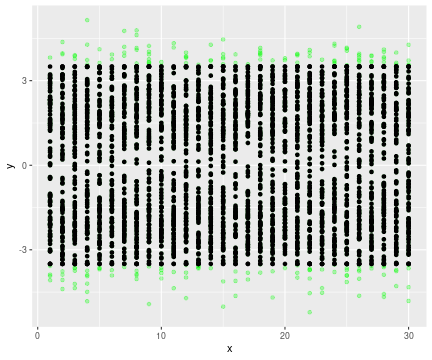

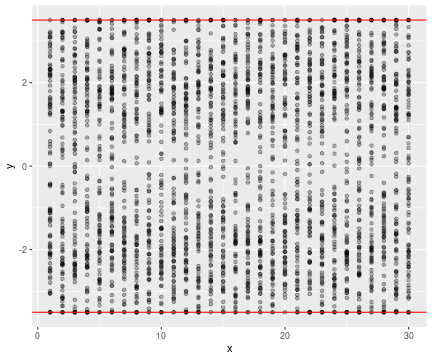

RObject{VecSxp}


In [40]:
using RCall 
@rput ylist_orig
@rput ylist_censored
R"""
library(tidyverse)
TT = 30

## Plot original data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", ylist_orig)
dt_orig = tibble(x=x, y=y)
g2 = ggplot(dt_orig) + geom_point(aes(x=x, y=y), col = 'green', alpha = .3) + geom_point(aes(x=x, y=y), alpha = 1, data = dt)
plot(g2)

## Plot censored data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", y_censored)
dt = tibble(x=x, y=y)
g = ggplot(dt) + geom_point(aes(x=x, y=y), alpha = .3) +
    geom_hline(yintercept = c(-3.5, 3.5), col = 'red')
"""

We can visualize the censoring; the green points have been censored to the red points.

# A tibble: 3,000 × 5
       x xjitter     orig censored cut  
   <int>   <dbl>    <dbl>    <dbl> <lgl>
 1     1   0.995 2.23     2.23     FALSE
 2     1   0.865 2.18     2.18     FALSE
 3     1   0.965 3.08     3.08     FALSE
 4     1   0.993 3.82     3.5      TRUE 
 5     1   0.952 1.93     1.93     FALSE
 6     1   0.846 1.80     1.80     FALSE
 7     1   1.15  0.000865 0.000865 FALSE
 8     1   0.817 0.461    0.461    FALSE
 9     1   1.02  2.33     2.33     FALSE
10     1   0.900 2.04     2.04     FALSE
# … with 2,990 more rows


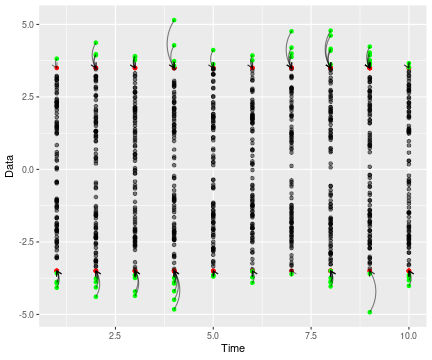

RObject{VecSxp}


In [67]:
@rput ylist_orig
@rput ylist_censored
R"""
library(tidyverse)
TT = 30
cut_limits = c(-3.5,3.5)


dt = lapply(1:TT, function(tt){
  y_censored = ylist_censored[[tt]]
  y_orig = ylist_orig[[tt]]
  cut = (y_censored %in% cut_limits)
  tibble(x = tt,
         xjitter = tt + runif(length(y_orig), -0.2, +0.2),  ## jittering the x's for visualization
         orig = y_orig, 
         censored = y_censored,
         cut = cut)
}) %>% bind_rows()
print(dt)

g = dt %>% subset(x <= 10) %>% ggplot() + 
geom_point(aes(x=x, y=censored), col = 'red', data = .%>% subset(cut == 1)) +
geom_point(aes(x=x, y=orig), alpha = .5, data = . %>% subset(cut == 0)) +
geom_point(aes(x=x, y=orig), data = . %>% subset(cut==1), col = 'green') +
geom_curve(aes(x = x, y = orig, xend = x, yend = censored, ),
                  arrow = arrow(length = unit(0.2, "cm")), alpha = .5, 
                curvature = .3,    
              data = . %>% subset(cut == 1)
             ) +
ylab("Data") +
xlab("Time") 
"""

Next, load the MCMC results and make a plot of the imputed data.

In [70]:
pos = fitdata["pos"]

nsam = length(pos["sigma1"])
nburn = div(nsam, 4)
nthin = div(nsam-nburn,2000)
keep_index = [nburn+nthin;] ## Taknig the last guy?
nkeep = length(keep_index)

sigma1_save = pos["sigma1"][keep_index];
sigma2_save = pos["sigma2"][keep_index];
mu1_save = pos["mu1"][keep_index,:];
mu2_save = pos["mu2"][keep_index,:];
phi1_save = pos["phi1"][keep_index,:];
w1_save = exp.(phi1_save) ./ (exp.(phi1_save) .+ 1);


_y_save = pos["_y"][keep_index];
ylist_impute_mean = mean(_y_save);

In [73]:
@rput ylist_impute_mean
R"""
#png("imputed.png")
#plot(x=rep(1,100), y= y_impute_mean[[1]], xlim=c(1,30), ylim=c(min(unlist(y_impute_mean)),max(unlist(y_impute_mean))), col="red", ylab="y", xlab="t")
#for(i in 2:30)
#{    
#    points(x=rep(i,length(y_impute_mean[[i]])), y=y_impute_mean[[i]], col="red")
#    # hist(y[[i]])
#}
#dev.off() 

library(tidyverse)
print(y_impute_mean)

dt = lapply(1:TT, function(tt){
  y_censored = ylist_censored[[tt]]
  y_orig = ylist_orig[[tt]]
  cut = (y_censored %in% cut_limits)
  tibble(x = tt,
         xjitter = tt + runif(length(y_orig), -0.2, +0.2),  ## jittering the x's for visualization
         orig = y_orig, 
         censored = y_censored,
         cut = cut)
}) %>% bind_rows()
print(dt)


#g = dt %>% subset(x <= 10) %>% ggplot() + 
#geom_point(aes(x=x, y=censored), col = 'red', data = .%>% subset(cut == 1)) +
#geom_point(aes(x=x, y=orig), alpha = .5, data = . %>% subset(cut == 0)) +
#geom_point(aes(x=x, y=orig), data = . %>% subset(cut==1), col = 'green') +
#geom_curve(aes(x = x, y = orig, xend = x, yend = censored, ),
#                  arrow = arrow(length = unit(0.2, "cm")), alpha = .5, 
#                curvature = .3,    
#              data = . %>% subset(cut == 1)
#) +
#ylab("Data") +
#xlab("Time") 
"""

[[1]]
  [1]  2.2272828009  2.1764256784  3.0835338355  3.5491165319  1.9298882247  1.7980656293  0.0008652933  0.4608726628
  [9]  2.3290767978  2.0389721102  1.4202503219  1.2678574407  2.9205631515  2.9671494788  2.4367314771  2.6202112646
 [17]  1.2238725028  2.1980294579  1.2639291676  1.5820382433  3.1546832789  2.3179835681  0.5972910459  2.2478050242
 [25]  1.4046969685  2.8249570459  2.1365999873  3.0965245059  3.1900368071  0.8394216284  2.8879849176  2.7395385442
 [33]  1.4856478692  1.6493289302  2.3228495159  2.3057968819  1.4908296739  1.4669223550  1.3455094493  0.5250447033
 [41]  2.6515552440 -0.4790990785  1.5396000928  2.3216851851  0.3014885577  3.2218015387  1.6192264092  3.0809747365
 [49]  2.1658308314  2.3951541120 -2.4371721390 -2.1104263463 -1.2377801191 -1.8746738773 -3.8136111421 -2.7912741624
 [57] -2.0574402846  0.0493502407 -1.6762640230 -0.4193396021 -1.9581997578 -2.4442669611 -1.6427780166 -2.6895366179
 [65] -1.0116097639 -3.0396243974 -1.1161400814 -3

 [67] -2.0686785 -1.6441107 -0.3404384 -0.5256885 -3.5922430 -1.5010804 -2.5573821 -2.6836870 -2.3606712 -3.5825443 -3.6477796
 [78] -0.3913253 -2.5861107 -0.8605309 -3.7787108 -2.2850448 -0.9705233 -1.4668243 -1.9795320 -1.9056646 -3.2722894 -1.5072233
 [89] -2.5327639 -3.1330629 -1.7943062 -2.5760077 -3.3073641 -1.3130369 -1.1770520 -1.4964839 -2.0027537 -1.4823348 -2.4713438
[100] -2.2674742

[[11]]
  [1]  1.8544083  2.4377547  3.2693923 -0.2920058  0.8626793  3.4541763  1.7308203  1.2469311  2.4585171  1.5081807  2.5349007
 [12] -1.2454949  2.0757761  0.6490228  2.1987146  2.2222195  1.1022823  1.9058659  1.8895764  0.6734011  1.5077237  2.0945890
 [23]  0.5981742  1.5768401  2.7092426  3.5200854 -0.6332767  1.6505628  0.9706651  1.2703619  2.5678662  1.8223855  0.7957954
 [34]  1.5297937  1.8908885  2.5702344  0.1412015  1.4276858  1.4887314  2.1252909  2.2549914  1.0377861  1.4129668  2.1609924
 [45]  4.6119968  0.8386895  2.7849438  0.7791095  1.3521297  2.7907278 -2.4113170 -1.

 [56] -2.0572692 -1.6744183 -2.3073790 -1.2111918 -2.4038466 -2.4982716 -1.3658935 -1.8128533 -3.7158531 -2.6009117 -2.0510791
 [67] -2.3064745 -1.9214153 -2.8100863 -1.1811342 -2.2012207 -1.3548685 -1.5834696 -2.3282850 -2.2791481 -2.0479400 -0.6865859
 [78] -1.5589453 -1.0008265 -2.5260844 -2.5753681 -2.9824324 -1.2467268 -3.0715306 -2.4807321 -1.8048974 -0.7845244 -1.3074028
 [89] -2.9062492 -0.8926946 -1.6480629 -1.8158357 -2.8440749 -2.8372147 -3.1522864 -1.7251987 -0.6702978 -1.3736488 -1.1657257
[100] -1.9520980

[[21]]
  [1]  2.82528568  2.77015161  1.04190032  2.86477073  2.60711515  1.11670101  2.58796644  1.34925743  2.42128121  4.06893797
 [11]  1.33751969  1.73583457  1.46733759  3.13338333  3.50750002  2.11476330  3.10517403  1.22571821  3.50658739  1.99480439
 [21]  2.43108213  1.63563207  2.11441270  2.46784845  1.98409045  3.74753106  2.99983669  1.61601289  0.95699053  0.69589247
 [31]  0.36995788  2.05644717  1.10102332  3.46242476  2.25438838  3.13992277  2.76354772

 [89] -1.7056541 -1.4762147 -3.6002358 -1.2598949 -1.0774491 -2.3591895 -3.5475576 -2.1700746 -1.0216370 -1.1749184 -0.6416526
[100] -0.7043900

[[29]]
  [1]  2.0703589  1.2643092  2.7424704  0.3165335  1.4283060  1.9543649  1.9954908  3.5888882  2.9418571  1.1243611  3.6335573
 [12]  0.7829259  2.7509325  2.5229739  2.8751565  1.4101130  2.5544656  1.2247371  1.2289688  1.0801222  2.1521995  1.9650200
 [23]  3.2904652  1.4110205  1.1028843  1.3196228  0.9099352  3.4708833  2.8352816  2.7520958  2.0525391  1.9529539  1.3833853
 [34]  1.6582676  1.1985566  2.2044550  1.8076860  3.3977545  2.2087113  0.8407877  1.1231744  3.3691084  1.3940849  1.3875456
 [45]  1.3801676  4.2392293  1.5834302  2.0067724  3.5678079  3.1541635 -3.0649703 -3.0317141 -1.7522789 -0.6406787 -2.5327586
 [56] -2.3357973 -1.3851004 -0.2509286 -2.5164227 -1.2599207 -1.6358557 -2.9706050 -2.2462346 -1.6450530 -3.5886564 -1.5470870
 [67] -0.9201621 -1.6233199 -3.1796620 -1.7929673 -1.8218834  0.1053998 -3.0967626 -1.

RObject{VecSxp}
[[1]]
  [1]  2.2272828009  2.1764256784  3.0835338355  3.5491165319  1.9298882247  1.7980656293  0.0008652933  0.4608726628
  [9]  2.3290767978  2.0389721102  1.4202503219  1.2678574407  2.9205631515  2.9671494788  2.4367314771  2.6202112646
 [17]  1.2238725028  2.1980294579  1.2639291676  1.5820382433  3.1546832789  2.3179835681  0.5972910459  2.2478050242
 [25]  1.4046969685  2.8249570459  2.1365999873  3.0965245059  3.1900368071  0.8394216284  2.8879849176  2.7395385442
 [33]  1.4856478692  1.6493289302  2.3228495159  2.3057968819  1.4908296739  1.4669223550  1.3455094493  0.5250447033
 [41]  2.6515552440 -0.4790990785  1.5396000928  2.3216851851  0.3014885577  3.2218015387  1.6192264092  3.0809747365
 [49]  2.1658308314  2.3951541120 -2.4371721390 -2.1104263463 -1.2377801191 -1.8746738773 -3.8136111421 -2.7912741624
 [57] -2.0574402846  0.0493502407 -1.6762640230 -0.4193396021 -1.9581997578 -2.4442669611 -1.6427780166 -2.6895366179
 [65] -1.0116097639 -3.0396243974 

Next, we make a plot with the following features (TODO: actually do this)
- Cluster means ($\{\mu_{kt}, t=1,\cdots, T\}, k=1,2$) over time,
- 95% probability regions (bands) for each cluster using,
- Cluster means' thickness are proportional to the cluster probabilities ($\{\pi_{kt}, t=1,\cdots, T\}, k=1,2$).

Next, we plot the true cluster probabilities against the estimated ones.

Next, we plot the imputed data.

We shorten the distance between the two cluster means (TODO: one setup is for when the cluster means touch but don't cross; another setup is for when cluster means actually cross).

We also compare it against several other competing methods. The main competitor is a 2-cluster Gaussian mixture model applied to each timepoint separately. At each time point, the cluster with the higher mean $\mu_{kt}$ is called cluster 2, and the other one is cluster 1. The analyses are repeated with this model.